<a href="https://colab.research.google.com/github/algroznykh/notebooks/blob/master/NCA_FROM_SCRATCH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sat Sep 26 05:27:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Imports and utils


In [1]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

from PIL import Image

import numpy as np


import tensorflow as tf
from tensorflow.keras.layers import Conv2D

tf.config.run_functions_eagerly(True)  # to not redefine life_step each time



In [2]:

def imshow(im, scale=(512, 512), index=0):
    return Image.fromarray(im).resize(scale, resample=Image.NEAREST)

# x[0,:,:,-3:].shape


def to_rgb(x):
    return np.array(x[:,:,:,:4] * 255, dtype='uint8')

In [ ]:
def movie(x, nframes=20):
    !mkdir frames
    !rm frames/*.png
    for i in range(nframes):
        imshow(to_rgb(x)[0]).save('frames/{:05d}.png'.format(i))
        x = ca(x)

    !ffmpeg -i frames/%05d.png -c:v libx264 -vf fps=8 -pix_fmt yuv420p movie.mp4 -y -loglevel quiet

    %clear
    import moviepy.editor as mpy


    display(mpy.ipython_display("movie.mp4", height=512))



In [ ]:
def init_x():
    return np.array(np.random.rand(1, TARGET_SIZE, TARGET_SIZE, CHN) / 10 + 0.5, dtype='float32')

# BASE

--2020-09-29 09:13:22--  https://github.com/googlefonts/noto-emoji/raw/master/png/128/emoji_u1f7e3.png
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/googlefonts/noto-emoji/master/png/128/emoji_u1f7e3.png [following]
--2020-09-29 09:13:22--  https://raw.githubusercontent.com/googlefonts/noto-emoji/master/png/128/emoji_u1f7e3.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3662 (3.6K) [image/png]
Saving to: ‘emoji.png’

emoji.png           100%[===================>]   3.58K  --.-KB/s    in 0s      

2020-09-29 09:13:22 (53.8 MB/s) - ‘emoji.png’ saved [3662/3662]

FINISHED --2020-09-29 09:13:2

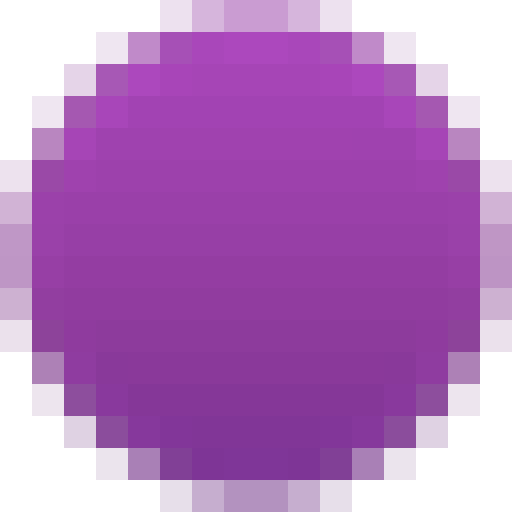

In [34]:

# TARGET_EMOJI = '💤'
# TARGET_EMOJI = '🦎'
TARGET_EMOJI = '🟣'
# TARGET_EMOJI = '🟥'
TARGET_SIZE = 16

def load_emoji(emoji):
    code = hex(ord(emoji))[2:].lower()
    url = 'https://github.com/googlefonts/noto-emoji/raw/master/png/128/emoji_u%s.png'%code
    with open('url.txt', 'w') as f:
        f.write(url)
    !wget -i url.txt -O emoji.png

load_emoji(TARGET_EMOJI)
target = np.array(Image.open('emoji.png').resize((TARGET_SIZE, TARGET_SIZE))) / 255

imshow(np.array(target * 255, dtype='uint8'))

In [82]:

CHN = 16

def make_seed():
    seed = np.zeros([1, TARGET_SIZE, TARGET_SIZE, CHN], np.float32)
    seed[:, TARGET_SIZE//2 , TARGET_SIZE//2, 3:] = 1.0
    return seed

seed = make_seed()





In [325]:
def get_living_mask(x):
    alpha = x[..., 3:4]
    # print(alive_mask.shape)
    return tf.cast(tf.nn.max_pool2d(alpha, 3, 1, 'SAME') >= 0.1, tf.float32)

class CA((tf.Module)):
    def __init__(self):
        self.model = tf.keras.Sequential([
            Conv2D(128, 3, padding='same', activation=tf.nn.relu),  # try sin
            Conv2D(CHN, 1)
                ])

    @tf.function
    def __call__(self, x):
        return x + self.model(x)


class NCA((tf.Module)):
    def __init__(self):
        self.model = tf.keras.Sequential([
            Conv2D(128, 3, padding='same', activation=tf.nn.relu),
            Conv2D(CHN, 1, kernel_initializer=tf.zeros, use_bias=False)
                ])

    @tf.function
    def __call__(self, x):
        alive_mask = get_living_mask(x)
        # update_mask = tf.floor(tf.random.uniform(x[...,:1].shape) + 0.5)
        
        x += self.model(x)
        x *= alive_mask
        return x 


In [323]:
# pool = np.repeat(seed, 256, 0)

@tf.function
def train_step(x, step_n):
    # step_n = 50
    with tf.GradientTape() as g:
        # x = tf.repeat(seed, 4, 0)
        # x = seed
        diff_loss = 0.0

        for i in range(step_n):
            x = ca(x)
        
        for i in range(50):
            prev_x = x
            x = ca(x)
            diff_loss += tf.reduce_mean(tf.square(prev_x - x))

        target_loss = tf.reduce_mean(tf.square(x[...,:4] - target))
        
        # alpha_loss = tf.reduce_mean(tf.square(x[...,3:4]))

        loss = target_loss + diff_loss

    params = ca.trainable_variables
    grads = g.gradient(loss, params)
    grads = [g / (tf.norm(g)+1e-8) for g in grads ]

    trainer.apply_gradients(zip(grads, params))
    return loss, x



In [327]:
# init NCA. Careful, this could erase your progress
ca = NCA()


In [328]:
#@title Train Loop {vertical-output: true}

TARGET_SIZE = 32
N_STEPS = 16

# lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000],[ 1e-3, 3e-4])
lr = 1e-3
trainer = tf.optimizers.Adam(lr)
loss_log = []


pool = np.repeat(make_seed(), 16, 0)

for i in range(500):
    batch_idx = np.random.choice(len(pool), 8, replace=False)
    x0 = pool[batch_idx]
    x0[:1] = make_seed()
    loss, x = train_step(x0, N_STEPS)
    pool[batch_idx] = x
    loss_log.append(loss.numpy())
    if i%100 == 0:
        clear_output(True)
        display(imshow(to_rgb(x)[0]))
        plt.plot(loss_log, '.', alpha=0.3)
        plt.show()
        print(i, loss.numpy())

InvalidArgumentError: ignored

In [259]:
TARGET_SIZE = int(512/3)
movie(make_seed(), 512)

mkdir: cannot create directory ‘frames’: File exists


# DREAM 

In [282]:
# image initialization from tensorflow/lucid

def rfft2d_freqs(h, w):
    """Computes 2D spectrum frequencies."""

    fy = np.fft.fftfreq(h)[:, None]
    # when we have an odd input dimension we need to keep one additional
    # frequency and later cut off 1 pixel
    if w % 2 == 1:
        fx = np.fft.fftfreq(w)[: w // 2 + 2]
    else:
        fx = np.fft.fftfreq(w)[: w // 2 + 1]
    return np.sqrt(fx * fx + fy * fy)


def fft_image(shape, sd=None, decay_power=1):
    """An image paramaterization using 2D Fourier coefficients."""

    sd = sd or 0.01
    batch, h, w, ch = shape
    freqs = rfft2d_freqs(h, w)
    init_val_size = (2, batch, ch) + freqs.shape

    init_val = np.random.normal(size=init_val_size, scale=sd).astype(np.float32)
    spectrum_real_imag_t = tf.Variable(init_val)
    spectrum_t = tf.complex(spectrum_real_imag_t[0], spectrum_real_imag_t[1])

    # Scale the spectrum. First normalize energy, then scale by the square-root
    # of the number of pixels to get a unitary transformation.
    # This allows to use similar leanring rates to pixel-wise optimisation.
    scale = 1.0 / np.maximum(freqs, 1.0 / max(w, h)) ** decay_power
    scale *= np.sqrt(w * h)
    scaled_spectrum_t = scale * spectrum_t

    # convert complex scaled spectrum to shape (h, w, ch) image tensor
    # needs to transpose because irfft2d returns channels first
    image_t = tf.transpose(tf.signal.irfft2d(scaled_spectrum_t), (0, 2, 3, 1))

    # in case of odd spatial input dimensions we need to crop
    image_t = image_t[:batch, :h, :w, :ch]
    # image_t = image_t / 4.0  # TODO: is that a magic constant?
    return image_t / 10


def make_fft():
    return fft_image((1, TARGET_SIZE, TARGET_SIZE, CHN)).numpy()

In [114]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

# Maximize the activations of these layers
names = ['mixed4']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

@tf.function
def dream_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.reduce_mean(tf.square(act))
    losses.append(loss)

  return  tf.reduce_sum(losses)

In [8]:
@tf.function
def dream_step(x, way=50):
    with tf.GradientTape() as g:
        # x = seed
        # x = np.array(np.random.rand(1, TARGET_SIZE, TARGET_SIZE, CHN), dtype='float32')
        # x = init_x()

        # diff_loss = 0.0

        for i in range(way):
            x = ca(x)
        # target_loss = calc_loss(tf.transpose(x[0,:,:,:3], [2, 0, 1]), dream_model)
        loss = dream_loss(x[0,:,:,:3], dream_model) 

        # target_loss += tf.reduce_mean(tf.square(x[...,:4] - target))

        # loss = target_loss # + diff_loss 


    params = ca.trainable_variables
    grads = g.gradient(loss, params) 
    grads = [g / (tf.norm(g)+1e-8) for g in grads ]

    trainer.apply_gradients(zip(grads, params))
    return loss, x


In [276]:
class DCA((tf.Module)):
    def __init__(self):
        self.model = tf.keras.Sequential([
            Conv2D(128, 3, padding='same', activation=tf.sin),
            Conv2D(CHN, 1, kernel_initializer=tf.zeros, use_bias=False, activation=None)
                ])

    @tf.function
    def __call__(self, x):
        # alive_mask = get_living_mask(x)
        # update_mask = tf.floor(tf.random.uniform(x[...,:1].shape) + 0.5)
        
        x += self.model(x)
        # x *= update_mask
        # x *= alive_mask
        return x

In [283]:
CHN = 12
ca = DCA()

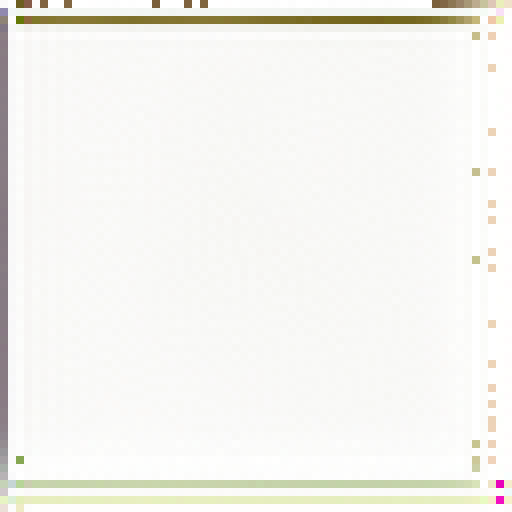

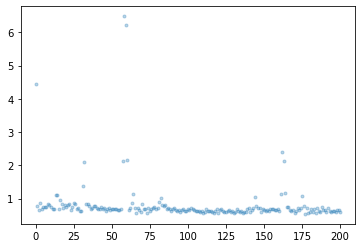

200 0.589665


KeyboardInterrupt: ignored

In [286]:
#@title Dream Loop {vertical-output: true}

TARGET_SIZE = 64
lr = 2e-3
N_STEPS = 32

loss_log = []
trainer = tf.optimizers.Adam(lr)

pool = np.repeat(make_fft(), 16, 0)

for i in range(50000):
    batch_idx = np.random.choice(len(pool), 8, replace=False)
    x0 = pool[batch_idx]

    x0[:1] = make_fft()
    loss, x = dream_step(x0, way=N_STEPS)
    pool[batch_idx] = x 
    loss_log.append(loss.numpy())
    if loss < 0.1:
        N_STEPS += 10
    if i%100 == 0:
        clear_output(True)
        # vis = np.stack(to_rgb(x0))
        display(imshow(to_rgb(x)[0]))
        plt.plot(loss_log, '.', alpha=0.3)
        plt.show()
        print(i, loss.numpy())

In [285]:
TARGET_SIZE = 64

# x = np.array(np.random.rand(1, TARGET_SIZE, TARGET_SIZE, CHN), dtype='float32')
# x = make_seed()
x = make_fft()

movie(x, 100)

mkdir: cannot create directory ‘frames’: File exists


# LIFE

In [ ]:
# why is convolution on ones with ones filter is not symmetrical? 
# todo look at filters more closely

tf.nn.conv2d(tf.stack([np.ones((3,3)) for _ in range(3)])[:,:,None,:], tf.stack([np.ones((3,3)) for _ in range(3)])[:,:,None,:], [1,1,1,1], 'SAME')

<tf.Tensor: shape=(3, 3, 1, 3), dtype=float64, numpy=
array([[[[2., 2., 2.]],

        [[3., 3., 3.]],

        [[2., 2., 2.]]],


       [[[2., 2., 2.]],

        [[3., 3., 3.]],

        [[2., 2., 2.]]],


       [[[2., 2., 2.]],

        [[3., 3., 3.]],

        [[2., 2., 2.]]]])>

In [ ]:
tf.nn.conv2d(tf.stack([np.ones((3,3)) for _ in range(3)])[:,:,None,:], tf.cast([[np.ones((3,3))]], dtype=np.double), [1,1,1,1], 'SAME')  # applause

<tf.Tensor: shape=(3, 3, 1, 3), dtype=float64, numpy=
array([[[[3., 3., 3.]],

        [[3., 3., 3.]],

        [[3., 3., 3.]]],


       [[[3., 3., 3.]],

        [[3., 3., 3.]],

        [[3., 3., 3.]]],


       [[[3., 3., 3.]],

        [[3., 3., 3.]],

        [[3., 3., 3.]]]])>

In [288]:
def show(x, size=256):
    return Image.fromarray(np.array(x[0, :,:,0] * 255, dtype='uint8')).resize((size,size), resample=Image.NEAREST)

In [289]:
def gs_movie(x, ca, nframes=20, height=512):
    !mkdir frames
    !rm frames/*.png
    for i in range(nframes):
        show((x)).save('frames/{:05d}.png'.format(i))
        x = ca(x)

    !ffmpeg -i frames/%05d.png -c:v libx264 -vf fps=8 -pix_fmt yuv420p movie.mp4 -y -loglevel quiet

    %clear
    import moviepy.editor as mpy


    display(mpy.ipython_display("movie.mp4", height=height))



In [301]:
# game of life on x

def init_life(p=0.5):
    x = np.array(np.random.rand(1, TARGET_SIZE, TARGET_SIZE, CHN) > p, dtype='float32')
    x[...,1:] = 0.0
    return x

def init_mandala():
    x = init_x()
    x[...,1:] = 0
    return x


def act(x):
    if 3 <= x <= 4:
        return 1
    return 0

filter = [[[[1], [1], [1]],
             [[1], [1], [1]],
             [[1], [1], [1]]]]


class Game():

    def __call__(self, x):
        # x = tf.nn.conv2d(x, filter, [1,1,1,1], 'SAME') #, activation=my_activation)
        x = tf.nn.conv2d(x[...,:1], np.array(filter).swapaxes(0, 2), [1,1,1,1], 'SAME')
        return np.array(np.vectorize(act)(x)[:,:,:,:1], dtype='int32')
        # return x


In [291]:
TARGET_SIZE = 3

In [311]:
@tf.function
def life_step(x, truths, way=50):
    with tf.GradientTape() as g:
        # game = dGame()
        # x = init_life()
        # truth = copy.copy(x)
        # x = np.array(np.random.rand(1, TARGET_SIZE, TARGET_SIZE, CHN), dtype='float32')
        # x = init_x()

        diff_loss = 0.0

        for i in range(way):
            x = ca(x)
            # x = tf.sin(x)
            # xs.append(x)
            # truth = game(truth)
            diff_loss += tf.reduce_mean(tf.abs(x[...,:1] - tf.cast(truths[i][...,:1], np.float32)))
            # diff_loss += tf.reduce_mean(tf.square(x[...,:1] - tf.cast(truths[i][...,:1], np.float32))) * 1/(i+1)


            # x = tf.nn.relu6(x)

        
        # x = ca(x)
        # diff_loss += tf.reduce_mean(tf.square(x[...,:1] - tf.cast(truths[i][...,:1], np.float32)))

        # target_loss = calc_loss(tf.transpose(x[0,:,:,:3], [2, 0, 1]), dream_model)
        # target_loss = dream_loss(x[0,:,:,:3], dream_model)

        

        # gray_loss = tf.reduce_mean(tf.abs(1 - tf.abs(np.median(x) - 0.5)))
        # ar_loss = 1/ (tf.math.reduce_variance(x) + 1e-8)

        loss = diff_loss
        # loss = tf.reduce_mean(tf.square(x[...,:1] - tf.cast(truths[-1][...,:1], np.float32)))


    params = ca.trainable_variables
    grads = g.gradient(loss, params) 
    grads = [g / (tf.norm(g)+1e-8) for g in grads ]

    trainer.apply_gradients(zip(grads, params))
    return loss, x


In [ ]:
ca.model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (1, None, None, 128)      18560     
_________________________________________________________________
conv2d_21 (Conv2D)           (1, None, None, 16)       2064      
Total params: 20,624
Trainable params: 20,624
Non-trainable params: 0
_________________________________________________________________


In [307]:
# todo: apply mask to set cells to zero or 1 

class LCA((tf.Module)):
    def __init__(self):
        self.model = tf.keras.Sequential([
            Conv2D(128, 3, padding='same', activation=tf.sin),
            Conv2D(CHN, 1, kernel_initializer=tf.zeros, use_bias=False, activation=None), 
                ])

    @tf.function
    def __call__(self, x):
        # alive_mask = get_living_mask(x)
        # update_mask = tf.floor(tf.random.uniform(x[...,:1].shape) + 0.5)
        
        x += self.model(x)
        # x *= update_mask
        # x *= alive_mask
        mask = tf.nn.max_pool2d(x, 1, [1, 1, 1, 1], 'SAME') > 0.1
        x *= tf.cast(mask, tf.float32)
        # x = tf.cast(tf.cast(x, tf.bool), tf.float32)
        return x
        # return tf.sin(x)
        # return tf.nn.relu6(x) / x


In [308]:
# careful
ca = LCA()


9500


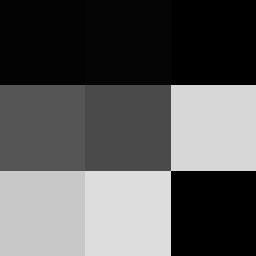

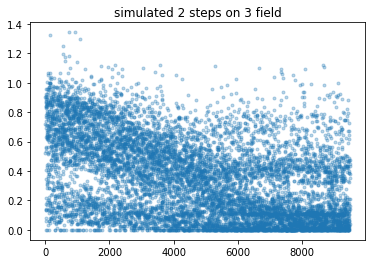

9500 0.16038862


In [312]:
#@title Sanity Check {vertical-output: true}
import copy
import random

CHN = 3
TARGET_SIZE = 3
STEP_N = 2
p = 0.5


lr = 1e-3
trainer = tf.optimizers.Adam(lr)
loss_log = []

# ca = GCA()
# ca = NCA()
# game = Game()

# start = init_x()

# start = game(init_life())

game = Game()

for i in range(10000):
    # start = init_mandala()
    start = init_life()

    # start = init_life(p)
    # start = game(init_x())
    y = copy.copy(start)
    ys = []
    # y = target[None,...,:1]
    for j in range(STEP_N):
        y = game(y)
        ys.append(y)
    loss, x = life_step(start, ys, STEP_N)


    # print(loss)
    loss_log.append(loss.numpy())
    if i%500 == 0:
        clear_output(True)
        print(i)

        display(show(x))
       
        plt.plot(loss_log, '.', alpha=0.3)
        plt.title('simulated {} steps on {} field'
            .format(STEP_N, TARGET_SIZE))
        plt.show()
        print(i, loss.numpy())

In [ ]:
ca.model

In [314]:
# ca = Game()
#
# ca = GCA()
TARGET_SIZE = 64

# x = np.array(np.zeros((1, TARGET_SIZE, TARGET_SIZE, 1)))
# x = init_life(0.5)
# x = init_x()
# x[...,1:] = 0
# x = seed


gs_movie(init_life(0.1), ca, 512, 512)

mkdir: cannot create directory ‘frames’: File exists


In [ ]:
np.stack([x[0, ..., 0], x[0,..., 1], x[0,..., 2]]).swapaxes(0,2).shape

(16, 16, 3)

In [185]:
def rgb_movie(x, indexes=(0, 1, 2), nframes=20, height=512):
    !mkdir frames
    !rm frames/*.png
    for i in range(nframes):
        # print(x.shape)
        imshow(np.array(np.stack([x[0, ..., indexes[0]], x[0,..., indexes[1]], x[0,..., indexes[2]]]) * 255, dtype='uint8').swapaxes(0,2)).save('frames/{:05d}.png'.format(i))
        x = ca(x)

    !ffmpeg -i frames/%05d.png -c:v libx264 -vf fps=8 -pix_fmt yuv420p movie.mp4 -y -loglevel quiet

    %clear
    import moviepy.editor as mpy


    display(mpy.ipython_display("movie.mp4", height=height))



In [131]:
TARGET_SIZE = 256

In [248]:
rgb_movie(init_mandala(), (0, 1, 2), 512)

mkdir: cannot create directory ‘frames’: File exists


In [ ]:
!ffmpeg -i movie.mp4 -vf scale=768:768 output.mp4

In [ ]:
def game_rgb_movie(x, nframes=100, height=512):
    !mkdir frames
    !rm frames/*.png
    for i in range(nframes):
        # print(x.shape)
        x = game(x)
        g = game(x)
        b = game(g)
        
        imshow(np.array(np.stack([x[0, ..., 0], g[0,..., 0], b[0,..., 0]]) * 255, dtype='uint8').swapaxes(0,2)).save('frames/{:05d}.png'.format(i))
        x = game(x)

    !ffmpeg -i frames/%05d.png -c:v libx264 -vf fps=8 -pix_fmt yuv420p movie.mp4 -y -loglevel quiet

    %clear
    import moviepy.editor as mpy


    display(mpy.ipython_display("movie.mp4", height=height))



In [ ]:
CHN = 16

In [ ]:
game_rgb_movie(init_x(), 1024)

mkdir: cannot create directory ‘frames’: File exists
rm: cannot remove 'frames/*.png': No such file or directory
Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2293760/45929032 bytes (5.0%)6406144/45929032 bytes (13.9%)10731520/45929032 bytes (23.4%)15048704/45929032 bytes (32.8%)19431424/45929032 bytes (42.3%)23715840/45929032 bytes (51.6%)27869184/45929032 bytes (60.7%)32227328/45929032 bytes (70.2%)36413440/45929032 bytes (79.3%)40534016/45929032 bytes (88.3%)44834816

In [ ]:


@tf.function
def rgb_life_step(x, truths, way=50):
    with tf.GradientTape() as g:
        # game = dGame()
        # x = init_life()
        # truth = copy.copy(x)
        # x = np.array(np.random.rand(1, TARGET_SIZE, TARGET_SIZE, CHN), dtype='float32')
        # x = init_x()

        # diff_loss = 0.0

        for i in range(way):
            x = ca(x)
            # xs.append(x)
            # truth = game(truth)
            # diff_loss += tf.reduce_mean(tf.square(x[...,:3] - tf.cast(truths[i][...,:3], np.float32)))  * (1 - 1/(i+1))

        # target_loss = calc_loss(tf.transpose(x[0,:,:,:3], [2, 0, 1]), dream_model)
        # target_loss = dream_loss(x[0,:,:,:3], dream_model) 
        loss = tf.reduce_mean(tf.square(x[...,:3] - tf.cast(truths[-1][...,:3], np.float32)))
        # gray_loss = tf.reduce_mean(tf.abs(1 - tf.abs(np.median(x) - 0.5)))
        # var_loss = 1/ (tf.math.reduce_variance(x) + 1e-8)
        # loss = target_loss # + diff_loss 
        # loss = diff_loss + var_loss


    params = ca.trainable_variables
    grads = g.gradient(loss, params) 
    grads = [g / (tf.norm(g)+1e-8) for g in grads ]

    trainer.apply_gradients(zip(grads, params))
    return loss, x


In [ ]:
r = game(x)
g = game(r)
b = game(g)

np.vstack([r, g, b]).swapaxes(0, -1).shape

(1, 64, 64, 3)

600


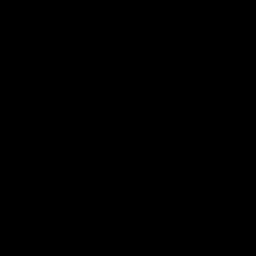

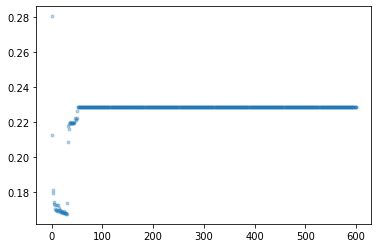

600 0.22851562


KeyboardInterrupt: ignored

In [ ]:
#@title RGB LOOP {vertical-output: true}
import copy


lr = 1e-3 
trainer = tf.optimizers.Adam(lr)
loss_log = []

# ca = GCA()
ca = NCA()
# game = Game()

STEP_N = 10

# start = game(init_x())
start = init_x()

for i in range(1000):
    # print(i)
    # start = init_x()
    # start = init_life(0.5)
    # start = game(init_x())
    y = copy.copy(start)
    ys = []
    # y = target[None,...,:1]
    for j in range(STEP_N):
        y = game(y)
        g = game(y)
        b = game(g)
        ys.append(np.vstack([y, g, b]).swapaxes(0, -1))
    loss, x = rgb_life_step(start, ys, STEP_N)

    # print(loss)
    loss_log.append(loss.numpy())
    if i%100 == 0:
        clear_output(True)
        print(i)

        display(show(x))
       
        plt.plot(loss_log, '.', alpha=0.3)
        plt.show()
        print(i, loss.numpy())

In [ ]:
movie(init_x())

mkdir: cannot create directory ‘frames’: File exists
